In [1]:
import xray
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.signal import hilbert
import matplotlib.dates as mdates

import seaborn as sns
from scipy import stats

from iwaves.utils.minmax import get_peak_window

from iwaves import IWaveModes
from iwaves.utils.density import FitDensity

from mycurrents import oceanmooring as om

from soda.utils.timeseries import timeseries
from soda.dataio.conversion.readotps import tide_pred


from matplotlib import rcParams



# Set font sizes
#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
#rcParams['font.serif'] = ['Bitstream Vera Sans']
rcParams["font.size"] = "18"
rcParams['axes.labelsize']='x-large'

#%matplotlib inline


In [23]:
"""
# KISSME data
dataset='KISSME'
ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/browse-basin-kissme/Data/NetCDF/KISSME_Fitted_Buoyancy_wout_motion.nc'

ncgroups = [\
    #'WP250',
    'NP250',
    #'SP250',
]

mode=0
outfile = '../Docs/IW_Params_KISSME_mode1.csv'

#mode=1
#outfile = '../Docs/IW_Params_KISSME_mode2.csv'
"""



# Crux data
dataset = 'CRUX'
#ncfile = '../../ShellCrux/KP150_Fitted_Buoyancy_wout_motion.nc'I#
ncfile = '../../ShellCrux/KP150_Fitted_Buoyancy_wout_motion_unvenfilt.nc'
ncgroups = [
    'KP150_phs1',
    'KP150_phs2',

]

mode=0
outfile = '../Docs/IW_Params_KP150_mode1.csv'
ampfile = '../DOCS/Crux_KP150_Phs2_a0_ssh.csv'

#mode=1
#outfile = '../Docs/IW_Params_KP150_mode2.csv'


"""
# Prelude data
dataset ='PRELUDE'
ncfile = '../../ShellPreludeRPS/Prelude_Fitted_Buoyancy.nc'
ncgroups = [\
    'F_Block_2007_CM04',\
    'F_Block_2008a_CM04',\
    'F_Block_2008b_CM04',\
    'F_Block_2009a_CM04',\
    'F_Block_2009b_CM04',\
]

mode=1
outfile = '../Docs/IW_Params_Prelude_mode2.csv'
"""

# Density params
zmax = -250
dz = 5
density_func='single_tanh'

# Tide model params
modfile = '/home/suntans/Share/ScottReef/DATA/TIDES/TPXO7.2/Model_tpxo7.2'
lon = np.array([123.3506])
lat = np.array([-13.7641])


ds = xray.open_dataset(ncfile, group=ncgroups[1])

ds

<xarray.Dataset>
Dimensions:   (freqs: 3, modes: 4, time: 271889, timeslow: 756, z: 100)
Coordinates:
  * modes     (modes) int64 0 1 2 3
  * time      (time) datetime64[ns] 2016-10-31T06:40:00 2016-10-31T06:41:00 ...
  * z         (z) float64 0.0 -2.525 -5.051 -7.576 -10.1 -12.63 -15.15 ...
  * timeslow  (timeslow) datetime64[ns] 2016-10-31T06:40:00 ...
  * freqs     (freqs) float64 0.0001405 0.000281 0.0004216
Data variables:
    Atide     (time, modes) float64 ...
    phi       (timeslow, modes, z) float64 ...
    rhofit    (time, z) float64 ...
    r10       (timeslow, modes) float64 ...
    rhobar    (timeslow, z) float64 ...
    amp       (timeslow, modes, freqs) float64 ...
    phs       (timeslow, modes, freqs) float64 ...
    A_n       (time, modes) float64 ...
    N2        (timeslow, z) float64 ...
    cn        (timeslow, modes) float64 ...
Attributes:
    Y:            -13.75897
    ncfile:       /home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/KP150_Gridd...
    group:    

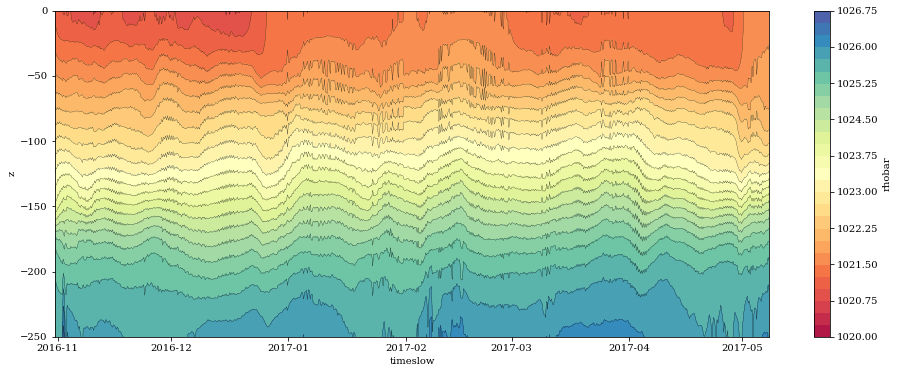

In [24]:
plt.figure(figsize=(16,6))
ds.rhobar.T.plot.contourf(levels=np.arange(1020,1027,0.25),  cmap='Spectral')
ds.rhobar.T.plot.contour(colors='k', levels=np.arange(1020,1027,0.25), linewidths=0.25,)

plt.show()

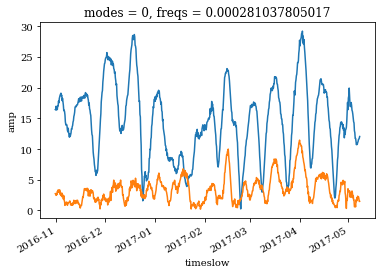

In [25]:
ds.amp[:,mode,0].plot()
ds.amp[:,mode,1].plot()

plt.show()

In [26]:
# get a tide prediction
def get_tide(myds):
    h,u,v = tide_pred(modfile, lon, lat, ds.time.values)

    ssh = xray.DataArray(h.ravel(), coords={'time':myds.time.values}, dims=('time',))
    
    # Get the RMS of the tidal elevation
    SSH = timeseries(ssh.time.values, ssh.values)

    SSHrms = timeseries(SSH.t, SSH.running_rms(SSH.y, 60*3600.))
    
    
    t,y = SSHrms.interp(myds.timeslow.values)

    ssh_pd = pd.Series(y, index=t, name='SSH')

    
    return ssh, ssh_pd

dsh, ssh_pd = get_tide(ds)

Interpolating consituent: M2...
Interpolating consituent: S2...
Interpolating consituent: N2...
Interpolating consituent: K2...
Interpolating consituent: K1...
Interpolating consituent: O1...
Interpolating consituent: P1...
Interpolating consituent: Q1...


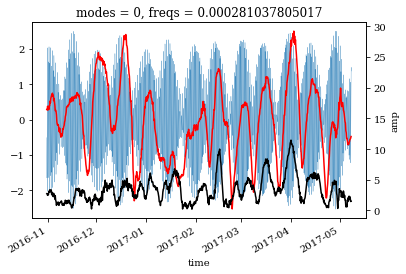

In [27]:
dsh.plot(lw=0.25)
ax2 = plt.twinx()
ds.amp[:,mode,0].plot(color='r',ax=ax2)
ds.amp[:,mode,1].plot(color='k',ax=ax2)


plt.show()

In [28]:
# Find the max amplitude for each time period
def get_Amax(ds):
    timeslow = ds.timeslow.to_index()
    Amax = np.zeros((timeslow.size,))
    ii=-1
    for t1, t2 in zip(timeslow[0:-1], timeslow[1::]):
        ii+=1
        A = ds.A_n.sel(time=slice(t1,t2))
        tmpmin = np.min(A[:,mode])
        tmpmax = np.max(A[:,mode])
        if np.abs(tmpmin) > tmpmax:
            tmp=tmpmin
        else:
            tmp=tmpmax
        if np.abs(tmp)>100.:
            Amax[ii]=Amax[ii-1]
        else:
            Amax[ii] = tmp
        #print t1, Amax[ii]    

    Amax_pd = pd.Series(Amax, index=timeslow, name='Amax')
    
    return Amax_pd


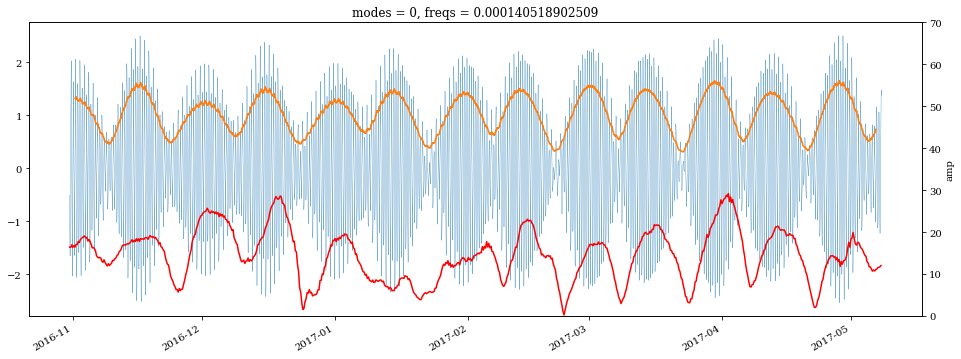

In [29]:
# Get the running RMS of the tidal elevation
SSH = timeseries(dsh.time.values, dsh.values)

SSHrms = timeseries(SSH.t, SSH.running_rms(SSH.y, 60*3600.))

plt.figure(figsize=(16,6))

SSH.plot(lw=0.3)
SSHrms.plot()

ax2 = plt.twinx()
ds.amp[:,mode,0].plot(color='r',ax=ax2)
#Amax_pd.plot(color='k', ax=ax2, lw=0.4)
#ds.amp[:,1,0].plot(color='k',ax=ax2)
ax2.set_ylim(0,70.)
plt.show()

In [30]:
# Convert both to pandas.Series objects
amp_pd = ds.amp[:,mode,0].to_series()

t,y = SSHrms.interp(ds.timeslow.values)

ssh_pd = pd.Series(y, index=t, name='SSH')

# Save as a csv
df = pd.DataFrame({'a0':amp_pd, 'ssh':ssh_pd})
df.to_csv(ampfile)

5


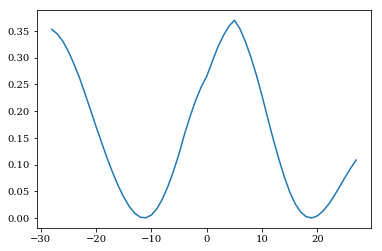

In [11]:
# cross-correlation
lags = range(-7*4,7*4)
 
xcov = np.array([amp_pd.corr(ssh_pd.shift(i)) for i in lags])**2.
idx = np.argmax(xcov)
print lags[idx]
plt.plot(lags, xcov)
plt.show()

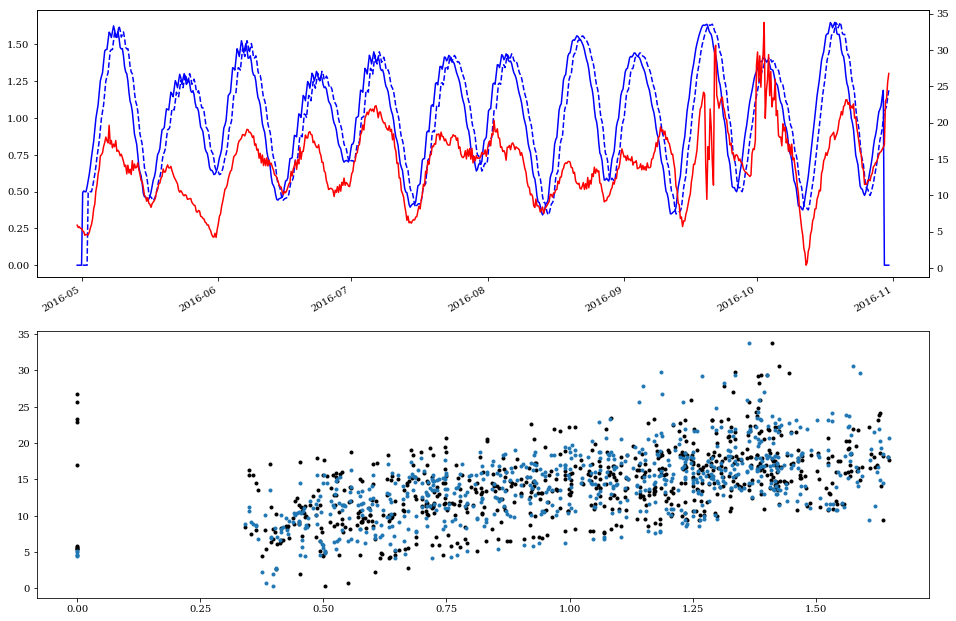

In [12]:
plt.figure(figsize=(16,12))
plt.subplot(211)
ssh_pd.plot(color='b')
ssh_pd.shift(lags[idx]).plot(color='b', ls='--')

ax2 = plt.twinx()
amp_pd.plot(color='r', ax=ax2)
plt.subplot(212)
plt.plot(ssh_pd, amp_pd, 'k.')

plt.plot(ssh_pd.shift(lags[idx]), amp_pd, '.')
plt.show()

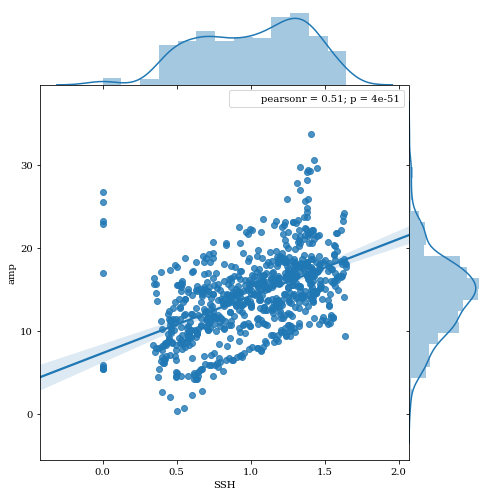

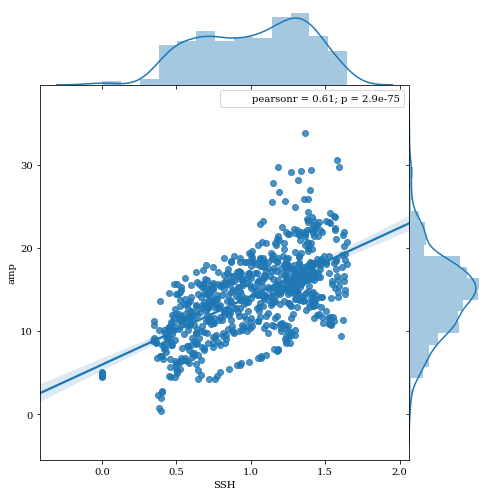

In [13]:
#g = sns.jointplot(ssh_pd.shift(lags[idx]), amp_pd, kind="reg", size=7, space=0)
g = sns.jointplot(ssh_pd, amp_pd, kind="reg", size=7, space=0)
plt.title('No-Phase Lag')

g = sns.jointplot(ssh_pd.shift(lags[idx]), amp_pd, kind="reg", size=7, space=0, stat_func=stats.pearsonr)
plt.title('With Phase Lag')
plt.show()

In [ ]:
# Extract the data from all groups
writestr =  'time,rho0,drho1,z1,h1,r10,r01,r20,h_e,c1,a0,Amax,eta\n'

f = open(outfile,'w')
f.write(writestr)

for ncgroup in ncgroups:
    ds = xray.open_dataset(ncfile, group=ncgroup)
    dsh, ssh_pd = get_tide(ds)
    Amax_pd = get_Amax(ds)


    for ii in range(ds.timeslow.size):
        T = ds.rhobar.values[ii,:]
        z = ds.z.values
        time = ds.timeslow.values[ii]
        iw = IWaveModes(T[::-1], z[::-1],  
            density_class=FitDensity, density_func=density_func)

        iw(zmax, dz, mode)
        params =  iw.calc_nonlin_params()

        ## For testing
        #plt.figure()
        #iw.plot_modes()
        #plt.show()

        # Create output string
        outstr = '%s, '%time
        if density_func=='double_tanh':
            outstr += 7*'%3.2f, '%tuple(iw.Fi.f0) # double tanh
        else:
            outstr += 4*'%3.2f, '%tuple(iw.Fi.f0)

        outstr += '%3.2e, %3.2f, %3.2e, %3.2f'%params
        outstr += ', %3.2f'%iw.c1

        outstr += ', %3.2f'%ds.amp[ii,mode,0]
        outstr += ', %3.2f'%Amax_pd[ii]

        outstr += ', %3.2f'%ssh_pd[ii]
        f.write('%s\n'%outstr)


        print outstr

f.close()

In [ ]:
data = pd.read_csv(outfile, index_col='time')
data 

In [ ]:
g = sns.jointplot('r10','Amax', data=data,\
    kind="reg", size=7, space=0, stat_func=stats.pearsonr)
plt.show()

In [ ]:
g = sns.jointplot('a0','Amax', data=data,\
    kind="reg", size=7, space=0, stat_func=stats.pearsonr)
plt.show()

In [ ]:
plt.figure(figsize=(8,7))
plt.scatter(data['r10'],data['Amax'], c=data['a0'], s=data['a0']*3, cmap='Spectral_r',alpha=0.8)
#plt.scatter(data['r10'],data['a0'], c=data['Amax'], cmap='Spectral_r',alpha=0.8)

plt.xlim(-3e-3, 3e-3)
plt.ylim(-100,100)
plt.colorbar()
plt.grid(b=True)
plt.ylabel('$A_{max}$ [m]')
plt.xlabel('$r_{10}$ [s$^{-1}$]')
plt.show()

# Calculate the steepening time and compare

Steepening time definition:

$$
\tau_s = \frac{1}{| 2 \pi \omega r_{10} a_0 |}
$$

In [ ]:
omega = 2*np.pi/(12.42*3600)
tau_s = 1/(2*np.pi*omega*data['r10']*data['a0'])
L_s = data['c1']*tau_s

#tau_s.plot()
#plt.show()
if mode==1:
    xlim = [0,200]
    ylim = [-70,70]
    vmax = 10.
    
if mode==0:
    xlim = [0,10000]
    ylim = [-70,70]
    vmax = 30.


plt.figure(figsize=(8,7))

#plt.semilogx(np.abs(tau_s)/3600., data['Amax'],'.')
plt.scatter(np.abs(tau_s)/3600.,data['Amax'], c=data['a0'], \
            s=np.abs(data['Amax'])*2, cmap='Spectral_r',alpha=0.8, vmax=vmax)
#plt.scatter(np.abs(tau_s)/86400., data['Amax'], \
#            c=np.abs(data['Amax']), s=np.abs(data['Amax'])*3, cmap='Spectral_r',alpha=0.8, vmin=0,vmax=60)

plt.grid(b=True)
plt.ylabel('$A_{max}$ [m]')
plt.xlabel(r'$\tau_s$ [hours]')
plt.gca().set_xscale('log')
plt.xlim(xlim)
plt.ylim(ylim)

cb=plt.colorbar()
cb.ax.set_title('$a_0$ [m]')

outfile = '../FIGURES/Amax_vs_taus_%s_mode%d'%(dataset, mode+1)
print outfile
plt.savefig('%s.png'%outfile, dpi=90)
plt.savefig('%s.pdf'%outfile, dpi=90)

plt.show()

In [ ]:
plt.figure(figsize=(8,7))

#plt.semilogx(np.abs(tau_s)/3600., data['Amax'],'.')
plt.scatter(np.abs(L_s)/1000.,data['Amax'], c=data['a0'], \
            s=np.abs(data['Amax'])*2, cmap='Spectral_r',alpha=0.8, vmax=vmax)
#plt.scatter(np.abs(tau_s)/86400., data['Amax'], \
#            c=np.abs(data['Amax']), s=np.abs(data['Amax'])*3, cmap='Spectral_r',alpha=0.8, vmin=0,vmax=60)

plt.grid(b=True)
plt.ylabel('$A_{max}$ [m]')
plt.xlabel(r'$L_s$ [km]')
plt.gca().set_xscale('log')
plt.xlim(9,1e5)
plt.ylim(ylim)

cb=plt.colorbar()
cb.ax.set_title('$a_0$ [m]')

outfile = '../FIGURES/Amax_vs_Ls_%s_mode%d'%(dataset, mode+1)
print outfile
plt.savefig('%s.png'%outfile, dpi=90)
plt.savefig('%s.pdf'%outfile, dpi=90)

plt.show()

In [ ]:
# Plot Amaxi
plt.figure(figsize=(8,7))

#plt.semilogx(np.abs(tau_s)/3600., data['Amax'],'.')
#plt.scatter(np.abs(tau_s)/3600.,data['Amax'], c=data['a0'], \
#            s=np.abs(data['Amax'])*2, cmap='Spectral_r',alpha=0.8, vmax=vmax)

plt.plot(np.abs(tau_s)/3600.
         ,data['Amax']/data['a0'],'o')
#plt.scatter(np.abs(tau_s)/86400., data['Amax'], \
#            c=np.abs(data['Amax']), s=np.abs(data['Amax'])*3, cmap='Spectral_r',alpha=0.8, vmin=0,vmax=60)

plt.grid(b=True)
plt.ylabel('$A_{max}$ [m]')
plt.xlabel(r'$\tau_s$ [hours]')
#plt.gca().set_xscale('log')
plt.xlim(xlim)
#plt.ylim(ylim)

#cb=plt.colorbar()
#cb.ax.set_title('$a_0$ [m]')

#outfile = '../FIGURES/Amax_vs_taus_%s_mode%d'%(dataset, mode+1)
#print outfile
#plt.savefig('%s.png'%outfile, dpi=90)
plt.show()

In [ ]:
datarho = data[['rho0', 'drho1','z1','h1']]
datarho.size

In [ ]:
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

g = sns.PairGrid(datarho, palette=["red"])
g.map_upper(plt.scatter, s=10)
g.map_diag(sns.distplot, kde=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)
plt.show()

In [ ]:
dataamp = data[['Amax', 'r10','a0']]
g = sns.PairGrid(dataamp, palette=["red"])
g.map_upper(plt.scatter, s=10)
g.map_diag(sns.distplot, kde=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)
plt.show()